# JUG Example: J1909-3744 (NANOGrav 15yr)

A complete walkthrough of JUG's capabilities: loading, inspecting,
fitting, noise modelling, whitening, and saving results.

**J1909-3744** is a high-precision millisecond pulsar in the NANOGrav
15-year narrowband dataset (35,037 TOAs, ELL1 binary, DMX, red noise).


In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from jug.engine.session import TimingSession


## 1. Load the pulsar


In [12]:
par = "../data/pulsars/NG_15yr_partim/J1909-3744_PINT_20220303.nb.par"
tim = "../data/pulsars/NG_15yr_partim/J1909-3744_PINT_20220303.nb.tim"

session = TimingSession(par, tim, verbose=True)


Opening session: J1909-3744_PINT_20220303.nb.par + J1909-3744_PINT_20220303.nb.tim
  Loaded 35037 TOAs
  Session ready


## 2. Inspect the session

`inspect()` lists everything you can do with the session.


In [13]:
session.inspect()


=== J1909-3744 - Available Inspections ===

Session methods:
  session.summary()                    - Overview of pulsar and data
  session.free_params                  - Parameters with fit flag on (from par file)
  session.set_free('F2', 'PX')         - Turn on fit flag for parameters
  session.set_frozen('PX')             - Turn off fit flag for parameters
  session.parameter_table()            - List all timing parameters
  session.parameter_table(fit_result)  - Compare pre/post-fit with uncertainties
  session.weighted_rms()               - Compute current weighted RMS (us)
  session.compute_residuals()           - Compute timing residuals
  session.fit_parameters(fit_params)    - Fit specified parameters
  session.get_initial_params()          - Original par file parameters
  session.save_par(path, fit_result)    - Write par file
  session.save_tim(path, deleted)       - Write tim file

Data attributes:
  session.params                       - Current parameters (1028 keys)
  ses

### 2a. Inspect the timing model

`print_model()` shows all parameters, their values, and whether they
are set to be fit (`[fit]`) or held fixed (`[frozen]`). These flags
come directly from the par file.


In [14]:
session.print_model()


=== Timing Model: J1909-3744 ===

-- Metadata --
  PSR                  J1909-3744
  EPHEM                DE440
  CLOCK                TT(BIPM2019)
  UNITS                TDB
  TIMEEPH              FB90
  T2CMETHOD            IAU2000B
  DILATEFREQ           N
  DMDATA               N
  NTOA                 35037.0
  START                53292.01653199197
  FINISH               58950.60796214824

-- Position --
  ECL                  IERS2010
  ELONG                284.22084587996807  [fit]
  ELAT                 -15.15553320954746  [fit]
  PMELONG              -13.869921797237843  [fit]
  PMELAT               -34.31363260467267  [fit]
  PX                   0.8909370620938715  [fit]
  POSEPOCH             56121.0000000000000000

-- Spin --
  F0                   339.31569232322724258  [fit]
  F1                   -1.6148082400121533993e-15  [fit]
  PEPOCH               56121.0000000000000000

-- Dispersion --
  DM                   10.3911722192288  [frozen]
  DM1                  0.0 

### 2b. Inspect the TOAs

`print_toas()` shows a summary of the TOA dataset: time span,
frequency range, error distribution, backends, and sample TOAs.


In [15]:
session.print_toas()


=== TOA Summary: J1909-3744 ===
  Total TOAs:     35037
  MJD range:      53292.017 - 58950.608
  Timespan:       15.49 years
  Freq range:     724.7 - 3974.9 MHz
  Error range:    0.0110 - 8.3840 us
  Median error:   0.5130 us

  Backends:
    3GHz_YUPPI                  3525 TOAs
    Rcvr1_2_GASP                 808 TOAs
    Rcvr1_2_GUPPI              20439 TOAs
    Rcvr_800_GASP                866 TOAs
    Rcvr_800_GUPPI              9399 TOAs

  Observatories:
    gbt                        31512 TOAs
    vla                         3525 TOAs

  First 10 TOAs:
                   MJD  Freq (MHz)  Error (us)          Backend     Obs
      53292.0165319917      1428.0       2.915     Rcvr1_2_GASP     gbt
      53292.0165319930      1424.0       1.786     Rcvr1_2_GASP     gbt
      53292.0165319957      1416.0       4.633     Rcvr1_2_GASP     gbt
      53292.0165319972      1412.0       1.695     Rcvr1_2_GASP     gbt
      53292.0165319986      1408.0       1.583     Rcvr1_2_GASP     g

### 2c. View the default fit parameters

`free_params` returns the list of parameters with fit flag = 1 in
the par file. This is what will be fit by default.


In [16]:
print(f"Number of free parameters: {len(session.free_params)}")
print()
# Show just the non-DMX free params for readability
non_dmx = [p for p in session.free_params if not p.startswith('DMX_')]
print("Free params (excluding DMX):", non_dmx)


Number of free parameters: 344

Free params (excluding DMX): ['A1', 'A1DOT', 'ELAT', 'ELONG', 'EPS1', 'EPS2', 'F0', 'F1', 'FD1', 'JUMP1', 'JUMP2', 'M2', 'PB', 'PBDOT', 'PMELAT', 'PMELONG', 'PX', 'SINI', 'TASC']


### 2d. Change fit flags

Use `set_free()` and `set_frozen()` to toggle which parameters are fit.
This is equivalent to changing the `1`/`0` flags in the par file.


In [17]:
# Freeze PX (parallax) and free F2 (spin-down second derivative)
session.set_frozen('PX')
session.set_free('F2')

# Check the change
non_dmx = [p for p in session.free_params if not p.startswith('DMX_')]
print("After set_frozen('PX'), set_free('F2'):")
print("Free params (excluding DMX):", non_dmx)
print()
print("Note: PX is gone, F2 is added")

# Restore for the fit below
session.set_free('PX')
session.set_frozen('F2')


After set_frozen('PX'), set_free('F2'):
Free params (excluding DMX): ['A1', 'A1DOT', 'ELAT', 'ELONG', 'EPS1', 'EPS2', 'F0', 'F1', 'F2', 'FD1', 'JUMP1', 'JUMP2', 'M2', 'PB', 'PBDOT', 'PMELAT', 'PMELONG', 'SINI', 'TASC']

Note: PX is gone, F2 is added


## 3. Compute and plot pre-fit residuals


In [18]:
result = session.compute_residuals(subtract_tzr=True)
residuals_us = result['residuals_us']
errors_us = np.array([t.error_us for t in session.toas_data])
mjd = np.array([t.mjd_int + t.mjd_frac for t in session.toas_data])
freq_mhz = np.array([t.freq_mhz for t in session.toas_data])

wrms = session.weighted_rms(residuals_us)
print(f"Pre-fit wRMS: {wrms:.4f} us")


  Computing residuals...
  Cached TOA data for fast postfit evaluation
Pre-fit wRMS: 0.3562 us


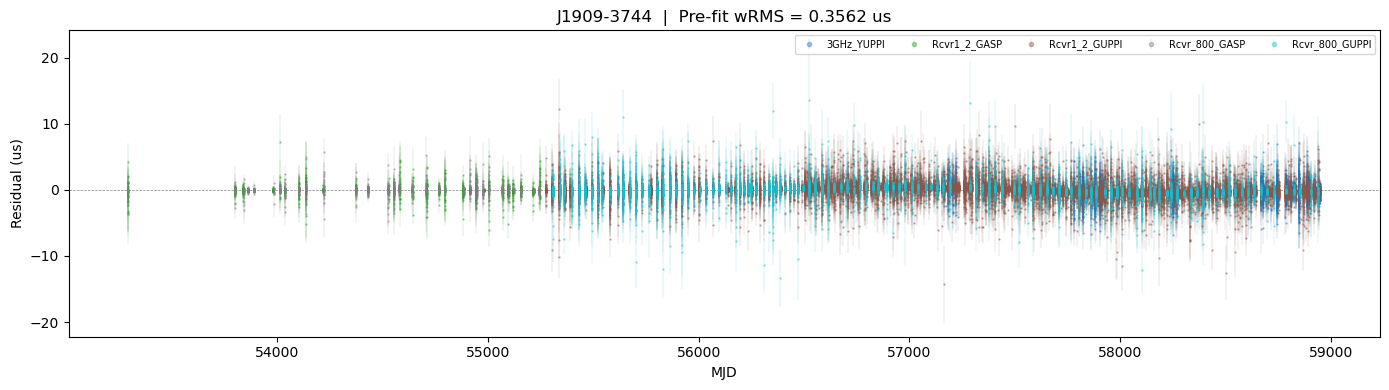

In [19]:
# Color by backend
from jug.engine.flag_mapping import resolve_backends

toa_flags = [t.flags for t in session.toas_data]
backends = resolve_backends(toa_flags)
unique_backends = sorted(set(backends))
backend_arr = np.array(backends)

cmap = plt.cm.tab10
backend_colors = {b: cmap(i / max(len(unique_backends) - 1, 1)) for i, b in enumerate(unique_backends)}

fig, ax = plt.subplots(figsize=(14, 4))
for backend in unique_backends:
    mask = backend_arr == backend
    ax.errorbar(mjd[mask], residuals_us[mask], yerr=errors_us[mask],
                fmt='.', ms=1.5, alpha=0.4, elinewidth=0.3,
                color=backend_colors[backend], label=backend)
ax.axhline(0, color='grey', ls='--', lw=0.5)
ax.set_xlabel("MJD")
ax.set_ylabel("Residual (us)")
ax.set_title(f"J1909-3744  |  Pre-fit wRMS = {wrms:.4f} us")
ax.legend(fontsize=7, ncol=len(unique_backends), loc='upper right', markerscale=4)
plt.tight_layout()
plt.show()


## 4. Fit timing parameters

Choose parameters to fit, or use `session.free_params` for the par file defaults.
The fitter uses weighted least squares with full noise-model support
(EFAC, EQUAD, ECORR, red noise).


In [20]:
import time

# fit_parameters() automatically fits all params flagged in the par file
t0 = time.time()
fit_result = session.fit_parameters(
    max_iter=5,
    verbose=True,
)
fit_time = time.time() - t0

postfit_us = fit_result['residuals_us']
postfit_wrms = session.weighted_rms(postfit_us)
print(f"\nFit time: {fit_time:.2f}s")
print(f"Post-fit wRMS: {postfit_wrms:.4f} us")
print(f"Iterations: {fit_result['iterations']}, Converged: {fit_result['converged']}")


TypeError: object of type 'NoneType' has no len()

## 5. Compare pre-fit vs post-fit parameters


In [ ]:
session.parameter_table(fit_result)


## 6. Fit with an additional parameter

Easily extend the fit. Here we add F2 (spin frequency second derivative).


In [ ]:
session.set_free('F2')

# fit_params adds F2 on top of the par-file free params
fit_result2 = session.fit_parameters(
    fit_params=['F2'],
    max_iter=5,
    verbose=True,
)

wrms2 = session.weighted_rms(fit_result2['residuals_us'])
print(f"\nwRMS with F2: {wrms2:.4f} us (was {postfit_wrms:.4f} us)")
print(f"F2 = {fit_result2['final_params'].get('F2', 'N/A')} +/- {fit_result2['uncertainties'].get('F2', 'N/A')}")

# Check updated model state
session.set_frozen('F2')  # restore


## 7. Noise realizations and whitened residuals

The fitter jointly solves for noise process coefficients. We can
extract them and subtract to get whitened residuals.


In [ ]:
noise = fit_result['noise_realizations']
print("Available noise realizations:", list(noise.keys()))

total_noise_us = np.zeros(len(postfit_us))
for key in noise:
    if not key.endswith('_err'):
        total_noise_us += noise[key]
        print(f"  {key}: RMS = {np.std(noise[key]):.4f} us")

whitened_us = postfit_us - total_noise_us
whitened_wrms = session.weighted_rms(whitened_us)
print(f"\nPost-fit wRMS:  {postfit_wrms:.4f} us")
print(f"Whitened wRMS:  {whitened_wrms:.4f} us")


In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

prefit_us = fit_result['residuals_prefit_us']
prefit_wrms = session.weighted_rms(prefit_us)
for backend in unique_backends:
    mask = backend_arr == backend
    axes[0].errorbar(mjd[mask], prefit_us[mask], yerr=errors_us[mask],
                     fmt='.', ms=1.2, alpha=0.3, elinewidth=0.2,
                     color=backend_colors[backend], label=backend)
axes[0].axhline(0, color='grey', ls='--', lw=0.5)
axes[0].set_ylabel("Residual (us)")
axes[0].set_title(f"J1909-3744  |  Pre-fit wRMS = {prefit_wrms:.4f} us")
axes[0].legend(fontsize=7, ncol=len(unique_backends), loc='upper right', markerscale=4)

for backend in unique_backends:
    mask = backend_arr == backend
    axes[1].errorbar(mjd[mask], postfit_us[mask], yerr=errors_us[mask],
                     fmt='.', ms=1.2, alpha=0.3, elinewidth=0.2,
                     color=backend_colors[backend])
axes[1].axhline(0, color='grey', ls='--', lw=0.5)
axes[1].set_ylabel("Residual (us)")
axes[1].set_title(f"Post-fit wRMS = {postfit_wrms:.4f} us")

for backend in unique_backends:
    mask = backend_arr == backend
    axes[2].errorbar(mjd[mask], whitened_us[mask], yerr=errors_us[mask],
                     fmt='.', ms=1.2, alpha=0.3, elinewidth=0.2,
                     color=backend_colors[backend])
axes[2].axhline(0, color='grey', ls='--', lw=0.5)
axes[2].set_xlabel("MJD")
axes[2].set_ylabel("Residual (us)")
axes[2].set_title(f"Whitened wRMS = {whitened_wrms:.4f} us")

plt.tight_layout()
plt.show()


### 7b. Post-fit residuals with noise realizations

Two-panel view: post-fit residuals (top) and the individual noise process
realizations (bottom) that the fitter jointly estimated.

In [ ]:
fig, (ax_res, ax_noise) = plt.subplots(2, 1, figsize=(14, 7), sharex=True,
                                        gridspec_kw={'height_ratios': [1, 1]})

# Top: post-fit residuals
for backend in unique_backends:
    mask = backend_arr == backend
    ax_res.errorbar(mjd[mask], postfit_us[mask], yerr=errors_us[mask],
                    fmt='.', ms=1.2, alpha=0.3, elinewidth=0.2,
                    color=backend_colors[backend], label=backend)
ax_res.axhline(0, color='grey', ls='--', lw=0.5)
ax_res.set_ylabel('Residual (us)')
ax_res.set_title(f'J1909-3744  |  Post-fit residuals (wRMS = {postfit_wrms:.4f} us)')
ax_res.legend(fontsize=7, ncol=len(unique_backends), loc='upper right', markerscale=4)

# Bottom: individual noise realizations
noise_cmap = plt.cm.Set2
noise_keys = [k for k in noise if not k.endswith('_err')]
for i, key in enumerate(sorted(noise_keys)):
    color = noise_cmap(i / max(len(noise_keys) - 1, 1))
    ax_noise.plot(mjd, noise[key], '.', ms=0.8, alpha=0.5, color=color, label=key)
ax_noise.axhline(0, color='grey', ls='--', lw=0.5)
ax_noise.set_xlabel('MJD')
ax_noise.set_ylabel('Noise realization (us)')
ax_noise.set_title('Noise process realizations')
ax_noise.legend(fontsize=8, loc='upper right')

plt.tight_layout()
plt.show()


### 7c. Whitened normalized residuals & Gaussianity test

Normalize the whitened residuals by dividing by the TOA uncertainties.
If the timing model and noise model are correct, the normalized residuals
should follow a standard normal distribution. A small mean offset is common
(absorbed by the timing model constant phase), so we also test after
subtracting the mean. The Anderson-Darling test quantifies departures
from Gaussianity: p > 0.05 indicates no significant departure.

In [ ]:
from scipy.stats import anderson, norm

# Normalized whitened residuals
whitened_norm = whitened_us / errors_us

# Anderson-Darling test (raw)
ad_stat, crit_vals, sig_levels = anderson(whitened_norm, dist='norm')
ad_pass = ad_stat < crit_vals[2]  # 5% significance level
print(f'Raw normalized residuals:')
print(f'  Mean offset:  {np.mean(whitened_norm):.4f} sigma')
print(f'  Std dev:      {np.std(whitened_norm):.4f}')
print(f'  AD statistic: {ad_stat:.4f}  (5% critical: {crit_vals[2]:.4f})')
print(f'  Gaussian:     {"Yes" if ad_pass else "No"}')

# Remove mean offset and re-test
whitened_centered = whitened_norm - np.mean(whitened_norm)
ad_stat2, crit_vals2, sig_levels2 = anderson(whitened_centered, dist='norm')
ad_pass2 = ad_stat2 < crit_vals2[2]
print(f'\nMean-subtracted normalized residuals:')
print(f'  AD statistic: {ad_stat2:.4f}  (5% critical: {crit_vals2[2]:.4f})')
print(f'  Gaussian:     {"Yes" if ad_pass2 else "No"}')

fig, axes = plt.subplots(1, 3, figsize=(16, 4),
                          gridspec_kw={'width_ratios': [2, 1, 1]})

# Left: time series of normalized whitened residuals
for backend in unique_backends:
    mask = backend_arr == backend
    axes[0].plot(mjd[mask], whitened_centered[mask], '.', ms=1.2, alpha=0.3,
                color=backend_colors[backend])
axes[0].axhline(0, color='grey', ls='--', lw=0.5)
axes[0].set_xlabel('MJD')
axes[0].set_ylabel('Normalized residual (sigma)')
axes[0].set_title('Whitened normalized residuals (mean-subtracted)')

# Middle: histogram (raw)
x_g = np.linspace(-5, 5, 200)
axes[1].hist(whitened_norm, bins=80, density=True, alpha=0.7, color='steelblue',
             edgecolor='none', label='Raw')
axes[1].plot(x_g, norm.pdf(x_g), 'r-', lw=1.5, label='N(0,1)')
axes[1].set_xlabel('Normalized residual')
axes[1].set_ylabel('Density')
axes[1].set_title(f'Raw  |  AD = {ad_stat:.2f}')
axes[1].legend(fontsize=8)

# Right: histogram (mean-subtracted)
axes[2].hist(whitened_centered, bins=80, density=True, alpha=0.7, color='seagreen',
             edgecolor='none', label='Centered')
axes[2].plot(x_g, norm.pdf(x_g), 'r-', lw=1.5, label='N(0,1)')
axes[2].set_xlabel('Normalized residual')
axes[2].set_ylabel('Density')
axes[2].set_title(f'Mean-subtracted  |  AD = {ad_stat2:.2f}')
axes[2].legend(fontsize=8)

plt.tight_layout()
plt.show()


## 8. Residuals vs observing frequency


In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
for backend in unique_backends:
    mask = backend_arr == backend
    ax.scatter(freq_mhz[mask], postfit_us[mask], s=0.5, alpha=0.3,
               color=backend_colors[backend], label=backend)
ax.axhline(0, color='grey', ls='--', lw=0.5)
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Post-fit Residual (us)")
ax.set_title(f"J1909-3744  |  Residuals vs Frequency")
ax.legend(fontsize=7, ncol=len(unique_backends), loc='upper right', markerscale=8)
plt.tight_layout()
plt.show()


## 9. MAP noise parameter estimation (optional)

JUG can estimate noise parameters using MAP estimation via SVI.
Requires `numpyro` and `pulsar-map-noise-estimates`.
Uncomment the cell below to run (~30-60 seconds).


In [ ]:
# from jug.noise.map_estimator import estimate_noise_parameters
#
# result_compute = session.compute_residuals(subtract_tzr=True)
# noise_result = estimate_noise_parameters(
#     residuals_sec=result_compute['residuals_us'] * 1e-6,
#     errors_sec=errors_us * 1e-6,
#     toas_mjd=mjd,
#     freq_mhz=freq_mhz,
#     toa_flags=toa_flags,
#     params=session.params,
#     include_red_noise=True,
#     include_dm_noise=True,
#     include_ecorr=True,
# )
# print("Estimated noise parameters:")
# for k, v in noise_result.params.items():
#     print(f"  {k}: {v}")


## 10. Timing summary


In [ ]:
print(f"Pulsar:          {session.params['PSR']}")
print(f"TOAs:            {len(session.toas_data)}")
print(f"Fitted params:   {len(session.free_params)}")
print(f"Fit time:        {fit_time:.2f}s")
print(f"Pre-fit wRMS:    {prefit_wrms:.4f} us")
print(f"Post-fit wRMS:   {postfit_wrms:.4f} us")
print(f"Whitened wRMS:   {whitened_wrms:.4f} us")
print(f"Chi-squared:     {fit_result['final_chi2']:.1f}")
print(f"Iterations:      {fit_result['iterations']}")
print(f"Converged:       {fit_result['converged']}")


## 11. Save fitted par and tim files


In [ ]:
session.save_par("/tmp/J1909-3744_jug_fitted.par", fit_result=fit_result)
print("Saved: /tmp/J1909-3744_jug_fitted.par")

session.save_tim("/tmp/J1909-3744_jug.tim")
print("Saved: /tmp/J1909-3744_jug.tim")


## 12. Round-trip verification

Load the saved par file back and verify residuals match.


In [ ]:
session2 = TimingSession("/tmp/J1909-3744_jug_fitted.par", tim, verbose=False)
result2 = session2.compute_residuals(subtract_tzr=True)
wrms_roundtrip = session2.weighted_rms(result2['residuals_us'])

print(f"Original post-fit wRMS:  {postfit_wrms:.6f} us")
print(f"Round-trip wRMS:         {wrms_roundtrip:.6f} us")
print(f"Difference:              {abs(postfit_wrms - wrms_roundtrip):.2e} us")


---
**Next steps:** Launch the interactive GUI with `jug-gui` for
point-and-click fitting, TOA deletion, and noise estimation.
